# **Historical data with Tzkt.io**
In this lesson you will learn:
- how to collect data from dex using tzkt.io
- collect historical data needed for testing bots
- we will build a chart that will help analyze the liquidity of the contract

First, install the necessary libraries for this lesson, and then move on to the theory

In [ ]:
%%capture
## %%capture is a Colab built-in function to suppress the output of that particular cell whether it uses a command-line code or some python code

from matplotlib import pyplot as plt
from pandas import json_normalize
import json
import pandas as pd
from tqdm import tqdm
import requests
import time
import seaborn as sns

# style of future grid for chart
sns.set_style("whitegrid")

## Task 1 
Study Rest API https://api.tzkt.io/#operation/Contracts_GetStorageHistory
We will use this "pen" to collect historical data

In [ ]:
#let's try

smart_contract ="KT1X3zxdTzPB9DgVzA3ad6dgZe9JEamoaeRy"

#to make it easier to see 
data = pd.DataFrame()

request_url = f'https://api.tzkt.io/v1/contracts/{smart_contract}/storage/history'

response = requests.get(request_url)
new_data = json_normalize(json.loads(response.text))
data = data.append(new_data)

data.tail()

,id,level,timestamp,operation.type,operation.hash,operation.counter,operation.parameter.entrypoint,operation.parameter.value.min_out,operation.parameter.value.receiver,value.storage.veto,value.storage.vetos,value.storage.votes,value.storage.ledger,value.storage.reward,value.storage.voters,value.storage.tez_pool,value.storage.token_id,value.storage.last_veto,value.storage.token_pool,value.storage.reward_paid,value.storage.total_votes,value.storage.total_reward,value.storage.total_supply,value.storage.user_rewards,value.storage.period_finish,value.storage.token_address,value.storage.reward_per_sec,value.storage.baker_validator,value.storage.last_update_time,value.storage.reward_per_share,value.storage.current_candidate,value.storage.current_delegated,value.metadata,value.dex_lambdas,value.token_lambdas,operation.parameter.value.amount,operation.parameter.value,operation.parameter.value.shares,operation.parameter.value.min_tez,operation.parameter.value.min_tokens
5,12457804,2119606,2022-02-15T10:36:14Z,transaction,opVT9iW4V8vkt565xRLQ1CJj24vM4qfPC6iExFK7zyTTw7...,50087120,tezToTokenPayment,118277090,tz1dzWtRX296zVUkB6tymqqCLkwsmwaxtrgP,155343,12077,12079,12075,54474664,12078,41602966090,0,2021-08-27T01:36:06Z,72102816425,418380312,6462501502,671460603,45739514007,12076,2022-02-22T13:24:06Z,KT193D4vozYnhGJQVtw7CoxxqphqUEEwK6Vb,57934389660493827,KT1DLRZD5XTQYydXzGuPhXUx8TdZR2WEmMGS,2022-02-15T10:03:14Z,15386223376141,tz1VQnqCCqX4K5sP3FNkVSNKTdCAMJDd3E1n,tz1UNkf4sWzC5vsKP7FnejSeJsXdc6z8Kzk4,12074,12073,12080,NaN,NaN,NaN,NaN,NaN
6,12456836,2119547,2022-02-15T10:03:14Z,transaction,ooheuyw1BvrYpY1a6C2iyWiwZhsdsPkvxDrMMugV2BUkcW...,24915422,withdrawProfit,NaN,NaN,155343,12077,12079,12075,54474664,12078,41534285043,0,2021-08-27T01:36:06Z,72221687873,418380312,6462501502,671460603,45739514007,12076,2022-02-22T13:24:06Z,KT193D4vozYnhGJQVtw7CoxxqphqUEEwK6Vb,57934389660493827,KT1DLRZD5XTQYydXzGuPhXUx8TdZR2WEmMGS,2022-02-15T10:03:14Z,15386223376141,tz1VQnqCCqX4K5sP3FNkVSNKTdCAMJDd3E1n,tz1UNkf4sWzC5vsKP7FnejSeJsXdc6z8Kzk4,12074,12073,12080,NaN,tz1VgNEbzuDj2BKzWaryUV6CJoDuNF5WupTM,NaN,NaN,NaN
7,12456777,2119545,2022-02-15T10:02:14Z,transaction,ookvBa1Ksh9a8AbcSFFQ88HidJ531MKkGasKdUBL7txnwL...,24915421,divestLiquidity,NaN,NaN,155343,12077,12079,12075,54474664,12078,41534285043,0,2021-08-27T01:36:06Z,72221687873,418346719,6462501502,671460603,45739514007,12076,2022-02-22T13:24:06Z,KT193D4vozYnhGJQVtw7CoxxqphqUEEwK6Vb,57934389660493827,KT1DLRZD5XTQYydXzGuPhXUx8TdZR2WEmMGS,2022-02-15T10:02:14Z,15386147379195,tz1VQnqCCqX4K5sP3FNkVSNKTdCAMJDd3E1n,tz1UNkf4sWzC5vsKP7FnejSeJsXdc6z8Kzk4,12074,12073,12080,NaN,NaN,86047957,77746139,135188493
8,12456368,2119514,2022-02-15T09:45:34Z,transaction,ooTu36A6BKy2PWTZQaBkws3CtVX5WAEKVDMWY6cBwkKPHe...,50593566,tokenToTezPayment,1253093,tz1QY3csufmdDSqA5jMcQ1LsAwAmcLVwQA46,155343,12077,12079,12075,54474664,12078,41612421867,0,2021-08-27T01:36:06Z,72357555706,418346719,6462501502,671460603,45825561964,12076,2022-02-22T13:24:06Z,KT193D4vozYnhGJQVtw7CoxxqphqUEEwK6Vb,57934389660493827,KT1DLRZD5XTQYydXzGuPhXUx8TdZR2WEmMGS,2022-02-15T08:16:14Z,15378106829283,tz1VQnqCCqX4K5sP3FNkVSNKTdCAMJDd3E1n,tz1UNkf4sWzC5vsKP7FnejSeJsXdc6z8Kzk4,12074,12073,12080,2218704,NaN,NaN,NaN,NaN
9,12455855,2119477,2022-02-15T09:25:54Z,transaction,ooCqJKd2tjxDa3XdqnYCy7WW7BacCGJJhSUyHm8AysJc9L...,50592171,tezToTokenPayment,746807,tz1VEna5sApZ4TDZ8c2tBF9qwpkmbrZNpoL9,155343,12077,12079,12075,54474664,12078,41613694042,0,2021-08-27T01:36:06Z,72355337002,418346719,6462501502,671460603,45825561964,12076,2022-02-22T13:24:06Z,KT193D4vozYnhGJQVtw7CoxxqphqUEEwK6Vb,57934389660493827,KT1DLRZD5XTQYydXzGuPhXUx8TdZR2WEmMGS,2022-02-15T08:16:14Z,15378106829283,tz1VQnqCCqX4K5sP3FNkVSNKTdCAMJDd3E1n,tz1UNkf4sWzC5vsKP7FnejSeJsXdc6z8Kzk4,12074,12073,12080,NaN,NaN,NaN,NaN,NaN


Let's assemble a function that makes a request according to the contract and takes into account pagination (lastId)

In [ ]:
# Parts of this code where taken from: https://github.com/ztepler/quipuswap-tezos-analysis-colab/blob/main/QuipuSwap_Tezos_Pool_Analysis.ipynb

def make_deep_requests(url, depth=5, limit=1000, sleep_time=2, stop_id=None):

    last_id = None

    #pandas dataframe where we will collect our data
    data = pd.DataFrame()

    #tqdm will show Progress bar
    for counter in tqdm(range(depth)):
        request_url = f'{url}&lastId={last_id}' if last_id else url

        try:
            response = requests.get(request_url)
            new_data = json_normalize(json.loads(response.text))
            data = data.append(new_data)

        except Exception as exception:
            print(exception)

        last_id = data.id.iloc[-1]

        if len(new_data) < limit:
            break

        if stop_id in data['id'].values:
            break

        time.sleep(sleep_time)

    return data
  
def collect_storage_history(smart_contract, depth=1, limit=1000):
    url = f'https://api.tzkt.io/v1/contracts/{smart_contract}/storage/history?limit={limit}'
    return make_deep_requests(url, depth=depth)

We do not need all the data from the storage, let's take the key: tez_pool/token_pool/timestamp

In [ ]:
def process_pool_data(df, token_decimals=6):

    convert = {
        'value.storage.tez_pool': lambda x: float(x) / 1_000_000,
        'value.storage.token_pool': lambda x: float(x) / (10**token_decimals),
        'timestamp': pd.Timestamp
    }

    for column_name, mapper in convert.items():
        df[column_name] = df[column_name].map(mapper)

    df['rate'] = df['value.storage.tez_pool'] / df['value.storage.token_pool']
    df = df.set_index('timestamp')
    return df

Calculations must be carried out in one dimension, which is why we convert Tezos to microTezos, and also take into account the decimals of tokens

## Task 2
Find any token from the list in the next cell and find its decimal in storage:
https://better-call.dev/  
For example Quipu: https://better-call.dev/mainnet/KT1K7whn5yHucGXMN7ymfKiX5r534QeaJM29/storage

In [ ]:
#@title QuipuSwap contracts and its decimals used in this token


tokens = dict(
    hDAO =     ('KT1QxLqukyfohPV5kPkw97Rs6cw1DDDvYgbB', 6),
    WRAP =     ('KT1FG63hhFtMEEEtmBSX2vuFmP87t9E7Ab4t', 8),
    tCow =     ('KT1XQZxsG4pMgcN7q7Nu3XFihsb9mEvqBmAT', 2),
    bDAO =     ('KT1DssMzoSr8fnUUq1WxeSuHfLG4gzS7pgge', 6),
    RSAL =     ('KT1WDe2vJCDqz5euKupppQsioPcakUd45Tfo', 0),
    tCowLP =   ('KT1UEfXGj5Ag73qCdZTk2534SZDT7cd7J8m8', 0),
    STKR =     ('KT1BMEEPX7MWzwwadW3NCSZe9XGmFJ7rs7Dr', 18),
    GUTS =     ('KT1WYQj3HEt3sxdsV4dMLA8RKzUnYAzXgguS', 0),
    Tacoz =    ('KT1VfiExduEkrpM4TbsnAw9QV1VURqaRFGKs', 18),
    token42 =  ('KT1M5H8qkJEzhdC3ZxZ78bSxgmcddrcusbry', 0),
    tSpanish = ('KT1A834QfnWremTQ4tc63s8NKbHzLJVszgxc', 0),
    DeanCoin = ('KT1BAPAVXMuYz63HrF9CGM9Gu8JVYTFpYqao', 6),
    tezos10x = ('KT1A4Sj8TBg4pazMkj226bAAcH6A4iCNQno4', 0),
    sDAO =     ('KT1PrRTVNgxkRgyqqNQvwTiVhd55dqyxXJ6n', 0),
    banana =   ('KT1Sd8jvepChHEHo63owNfjnqgzJEkUWSj9q', 2),
    SHTz =     ('KT1G7Z14RJLKbfu96Hc22bwNL67aykunAGyH', 2),

    sUSD =     ('KT1KFszq8UFCcWxnXuhZPUyHT9FK3gjmSKm6', 6),
    ETHtz =    ('KT1Evsp2yA19Whm24khvFPcwimK6UaAJu8Zo', 18),
    kUSD =     ('KT1K4EwTpbvYN9agJdjpyJm4ZZdhpUNKB3F6', 18),

    wUSDC =    ('KT1U2hs5eNdeCpHouAvQXGMzGFGJowbhjqmo', 6),
    wWETH =    ('KT1DuYujxrmgepwSDHtADthhKBje9BosUs1w', 18),
    RITA =     ('KT1L98jqwZtKUZbcPNxb3pTY7b2WXUGEzn8G', 6),
    MEL =      ('KT1BsDKTXBiYck85fJnoDzedyKKNtMuC9B9h', 6),
    BDoge =    ('KT1Th57AbgJmiZWDny6Ewqd2sx5qSxJwu8ry', 4),
    wMATIC =   ('KT1RsfuBee5o7GtYrdB7bzQ1M6oVgyBnxY4S', 18),

    TTT =      ('KT1WYoYSdHNmNJf9pHWPoHJWDA3bid1NP9SJ', 8),
    SOIL =     ('KT1NXdxJkCiPkhwPvaT9CytFowuUoNcwGM1p', 4),
    BART =     ('KT1WJVYEjLRirPQDSWqfggjqFGn14y9hiCBL', 9),
    NOLA =     ('KT1Fm5fS6VhFyE9wgopXcoQ3Nyb5awLY2sQH', 6),
    wSUSHI =   ('KT1Lotcahh85kp878JCEc1TjetZ2EgqB24vA', 18),
    CVZA =     ('KT1F3BqwEAoa2koYX4Hz7zJ8xfGSxxAGVT8t', 8),
    wDAI =     ('KT1PQ8TMzGMfViRq4tCMFKD2QF5zwJnY67Xn', 18),
    wLINK =    ('KT1Lpysr4nzcFegC9ci9kjoqVidwoanEmJWt', 18),
    tDAO =     ('KT1X6dAh8fwQMkWC9yh4yuvkJaS5NjqY4NvW', 4),
    rugDao =   ('KT1D3tdqrEkcwKkhJso5jmrJiyiaNVWtYiFJ', 2),
    DONTz =    ('KT1FaPEfr2hGTR1d4tN9VikubuSVS1CuuMJX', 2),
    BEEz =     ('KT1A4tYKJDJHrLonvp4qkJpZz5fkoWcAxMxW', 2),
    gDAO =     ('KT198myhugqAVvtNbYgN4sBKMFRYBvprcKHf', 6),
    wPAX =     ('KT1Ca5FGSeFLH3ugstc5p56gJDMPeraBcDqE', 18),
    WEED =     ('KT1TYjt5eLHRx3nQpSfaR94oQ6vehu24vvSQ', 8),
    wBTC =     ('KT1DksKXvCBJN7Mw6frGj6y6F3CbABWZVpj1', 8),
    SEB =      ('KT1S4WyNiYPoYheihysddNh5hojNFdiVBwZL', 2),

    CUU =      ('KT1W1hafYEzQkQLXyRPTxMeG3UaoUSsW7wNR', 2),
    HSK =      ('KT19HJTgEqnmi1cYyq8z2WFtyNTECodfixmj', 2),
    TITz =     ('KT1BNRefGboWR4p2SFwDDTosjnPKPL9hVk3q', 2),
    F15H =     ('KT1CNEgfKrGWtYdWAGG3cyZAUcFFpotmAme9', 2),
    FLAME =    ('KT1Q93ftAUzvfMGPwC78nX8eouL1VzmHPd4d', 6),
    BRR =      ('KT1PmH3JCEo65koqSGGUArKSpbKMN8dJ3BPZ', 6),

    BEEF =     ('KT1BtmMAnmTGHAA9ZV8xPzuwZu4ibL7f5qb3', 6),
    RTT =      ('KT1QoKSXVnvytnkbMLu8Nqh9vH9qPdtvxR6K', 2),
    tChicken = ('KT1JzZtBeHDBS9XyEqUc9nZhsqcfeNLxVV1T', 6),
    GSAL =     ('KT1BzNUUjURkTtNhXFkbGtu9fY3Q5scKZrvK', 0),
    sCAS =     ('KT1HhUWkzjmdjFTgNMmGgdNWGb6wwEXA4XCT', 0),
    CRUNCH =   ('KT1RRgK6eXvCWCiEGWhRZCSVGzhDzwXEEjS4', 8),
    Bezos =    ('KT1ETAtdv2PTvXwbGGsWWjnswfagdUc77hiP', 0),

    HEH =      ('KT1BgezWwHBxA9NrczwK9x3zfgFnUkc7JJ4b', 6),
    PLENTY =   ('KT1X1LgNkQShpF9nRLYw3Dgdy4qp38MX617z', 18),
    MAG =      ('KT1WREc3cpr36Nqjvegr6WSPgQKwDjL7XxLN', 6)
)

Let's test what we've got

In [ ]:
#@title Select token
token = "hDAO" #@param ['hDAO', 'WRAP', 'tCow', 'bDAO', 'sDAO', 'tCowLP', 'STKR', 'GUTS', 'Tacoz', 'token42', 'tSpanish', 'DeanCoin', 'tezos10x', 'RSAL', 'banana', 'SHTz', 'sUSD', 'ETHtz', 'kUSD', 'wUSDC', 'wWETH', 'RITA', 'MEL', 'BDoge', 'wMATIC', 'TTT', 'SOIL', 'BART', 'NOLA', 'wSUSHI', 'CVZA', 'wDAI', 'wLINK', 'tDAO', 'rugDao', 'DONTz', 'BEEz', 'gDAO', 'wPAX', 'WEED', 'wBTC', 'SEB', 'CUU', 'HSK', 'TITz', 'F15H', 'FLAME', 'BRR', 'BEEF', 'RTT', 'tChicken', 'GSAL', 'sCAS', 'CRUNCH', 'Bezos', 'HEH', 'PLENTY', 'MAG']
requests_depth = 3 #@param {type:"integer"}
contract_address = tokens[token][0]
token_decimals = tokens[token][1]

limit = 1000

Request data

In [ ]:
data = process_pool_data(
    collect_storage_history(contract_address, depth=requests_depth, limit=limit),
    token_decimals=token_decimals
)

100%|██████████| 3/3 [00:13<00:00,  4.35s/it]


Let's build a graph based on the data received

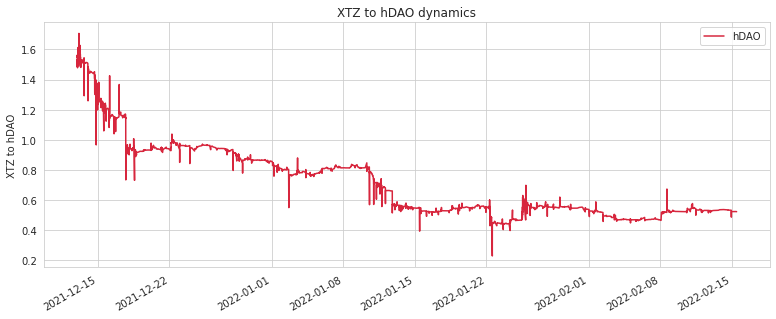

In [ ]:
data.rate.rename(f'{token}').plot(color='#D7263D', figsize=(13,5))

plt.xlabel('')
plt.ylabel(f'XTZ to {token}')
plt.legend()
_ = plt.title(f'XTZ to {token} dynamics')


## Task 3

Study best practicies from tzkt.io team:

*   https://baking-bad.org/blog/2020/07/29/tezos-explorer-api-tzkt-how-often-to-make-requests/
*   https://baking-bad.org/blog/2020/08/10/tezos-explorer-api-tzkt-request-only-what-you-need/
*   https://baking-bad.org/blog/2020/09/28/tezos-explorer-api-tzkt-filter-data-on-the-api/
  

